# 🧠 PART C

## 🔧 1. Setup
We begin by importing essential libraries and setting the device (CPU/GPU). We also configure plotting styles for later visualizations.


In [54]:
import os
import time
from typing import Any, Dict, List, Tuple

import pandas as pd
import torch
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)

# Install required dependencies.
# !pip install rouge_score datasets evaluate

from datasets import Dataset
import evaluate
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set device for model training/inference.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

Using device: cuda


## 📊 2. Plot Timing Utility
This function plots execution times for various pipeline steps, helping us understand time cost distribution (e.g., training, evaluation).


In [55]:
def plot_timing(timing_data: Dict[str, float], title: str = "Execution Time by Step"):
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("husl", len(timing_data))
    bars = plt.bar(timing_data.keys(), timing_data.values(), color=colors)

    plt.title(title, fontsize=14, pad=20)
    plt.ylabel("Time (seconds)", fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}',
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

## 📈 3. ROUGE Score Plot
Generates bar charts for ROUGE-1, ROUGE-2, and ROUGE-L scores comparing different decoding strategies or prompt types.


In [56]:
def plot_rouge_scores(rouge_data: Dict[str, Dict[str, float]],
                     model_name: str,
                     strategies: List[str]):
    metrics = ['rouge1', 'rouge2', 'rougeL']
    x = np.arange(len(metrics))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, strategy in enumerate(strategies):
        scores = [rouge_data[strategy][m] for m in metrics]
        offset = width * i
        rects = ax.bar(x + offset, scores, width, label=strategy)
        ax.bar_label(rects, padding=3, fmt='%.3f')

    ax.set_title(f'ROUGE Scores for {model_name}', fontsize=14, pad=20)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
    ax.legend(loc='upper right')
    ax.set_ylim(0, 1)

    fig.tight_layout()
    plt.show()

## 📋 4. ROUGE Table Printer
Prints a clean table of ROUGE scores for comparison across decoding strategies and prompts.


In [57]:
def print_rouge_table(rouge_data: Dict[str, Dict[str, float]], title: str):
    print(f"\n{title}")
    print("-" * 60)
    print("{:<15} {:<15} {:<15} {:<15}".format(
        "Strategy", "ROUGE-1", "ROUGE-2", "ROUGE-L"))
    print("-" * 60)

    for strategy, scores in rouge_data.items():
        print("{:<15} {:<15.4f} {:<15.4f} {:<15.4f}".format(
            strategy,
            scores['rouge1'],
            scores['rouge2'],
            scores['rougeL']))
    print("-" * 60)

## 📥 5. Data Loader
Loads training, validation, and test datasets from CSV files. The validation set is a random sample from the training data.


In [58]:
def load_data(train_path: str, test_path: str, val_size: int = 500) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    start_time = time.time()
    if not os.path.exists(train_path) or not os.path.exists(test_path):
        print("Train or test CSV file does not exist. Check the provided paths.")
        raise FileNotFoundError("Train or test CSV file not found.")

    train_df = pd.read_csv(train_path)
    val_df = train_df.sample(n=val_size, random_state=42)
    test_df = pd.read_csv(test_path)

    elapsed = time.time() - start_time
    print(f"Data loaded in {elapsed:.2f} seconds: Train shape = {train_df.shape}, Val shape = {val_df.shape}, Test shape = {test_df.shape}")
    return train_df, val_df, test_df

## 🧹 6. Preprocessing
Tokenizes the article `text` and the target `title`, preparing the dataset for training using the HuggingFace Trainer.


In [59]:
def preprocess(examples: Dict[str, Any],
               tokenizer: transformers.PreTrainedTokenizer,
               max_input_length: int = 512,
               max_target_length: int = 128) -> Dict[str, Any]:
    inputs = examples["text"]
    targets = examples["title"]
    tokenized_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding="max_length"
    )
    with tokenizer.as_target_tokenizer():
        tokenized_targets = tokenizer(
            targets,
            max_length=max_target_length,
            truncation=True,
            padding="max_length"
        )
    tokenized_inputs["labels"] = tokenized_targets["input_ids"]
    return tokenized_inputs

## 🔮 7. T5-based Title Generator
Generates titles from test text using the finetuned T5 model. Supports both greedy decoding and beam search.


In [60]:
def generate_titles_t5(model: transformers.PreTrainedModel,
                       tokenizer: transformers.PreTrainedTokenizer,
                       test_df: pd.DataFrame,
                       beam_search: bool = False,
                       max_new_tokens: int = 40) -> List[str]:
    predictions = []
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Generating titles"):
        inputs = tokenizer(
            row["text"],
            return_tensors="pt",
            max_length=512,
            truncation=True
        ).to(device)

        outputs = model.generate(
            inputs["input_ids"],
            max_new_tokens=max_new_tokens,
            num_beams=4 if beam_search else 1,
            early_stopping=True
        )
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(decoded)
    return predictions

## 🤖 8. Flan-T5 Prompted Generator
Generates titles using Flan-T5 models with prompt templates, allowing us to test different instruction styles.


In [61]:
def generate_titles_flan(model: transformers.PreTrainedModel,
                         tokenizer: transformers.PreTrainedTokenizer,
                         test_df: pd.DataFrame,
                         prompt_template: str,
                         beam_search: bool = False,
                         max_new_tokens: int = 40) -> List[str]:
    predictions = []
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Generating Flan titles"):
        prompted_text = prompt_template.format(row["text"])
        inputs = tokenizer(
            prompted_text,
            return_tensors="pt",
            max_length=512,
            truncation=True
        ).to(device)

        outputs = model.generate(
            inputs["input_ids"],
            max_new_tokens=max_new_tokens,
            num_beams=4 if beam_search else 1,
            early_stopping=True
        )
        decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(decoded_text)
    return predictions

## 🧪 9. Flan Evaluation Function
Evaluates a Flan-T5 model with different prompt styles and decoding strategies. It returns timing and ROUGE metrics.


In [62]:
def evaluate_prompts_flan(model_name: str,
                          test_df: pd.DataFrame,
                          prompts: Dict[str, str]) -> Dict[str, Any]:
    print(f"\nEvaluating {model_name} ...")
    start_time = time.time()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
    print(f"Model loading took {time.time() - start_time:.2f} seconds")

    rouge = evaluate.load("rouge")
    results = {}

    for prompt_name, prompt_template in prompts.items():
        print(f"\nEvaluating prompt: '{prompt_name}'")

        # Greedy decoding
        greedy_start = time.time()
        greedy_preds = generate_titles_flan(model, tokenizer, test_df, prompt_template, beam_search=False)
        greedy_time = time.time() - greedy_start
        greedy_scores = rouge.compute(predictions=greedy_preds, references=test_df["title"].tolist())
        print("Sample generated titles (Greedy):")
        for title in greedy_preds[:3]:
            print(f"- {title}")

        # Beam search decoding
        beam_start = time.time()
        beam_preds = generate_titles_flan(model, tokenizer, test_df, prompt_template, beam_search=True)
        beam_time = time.time() - beam_start
        beam_scores = rouge.compute(predictions=beam_preds, references=test_df["title"].tolist())
        print("Sample generated titles (Beam):")
        for title in beam_preds[:3]:
            print(f"- {title}")

        results[prompt_name] = {
            "greedy": {
                "time": greedy_time,
                "rouge1": greedy_scores['rouge1'],
                "rouge2": greedy_scores['rouge2'],
                "rougeL": greedy_scores['rougeL']
            },
            "beam": {
                "time": beam_time,
                "rouge1": beam_scores['rouge1'],
                "rouge2": beam_scores['rouge2'],
                "rougeL": beam_scores['rougeL']
            }
        }

    print(f"\nEvaluation for {model_name} completed in {time.time() - start_time:.2f} seconds")
    return results

## 🚀 10. Full Pipeline Execution
This is the main driver that orchestrates data loading, training, inference, evaluation, and visualization. Results are presented in both tabular and graphical form.



Step 1: Loading data...
Data loaded in 5.63 seconds: Train shape = (13879, 2), Val shape = (500, 2), Test shape = (100, 2)

Step 2: Setting up model and tokenizing data...


Map:   0%|          | 0/13879 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]


Step 3: Training the T5-small model...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-63-e3e1dab2c089>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,0.488400,0.018401
2,0.021500,0.015323
3,0.018900,0.014722



Step 4: Evaluating T5-small with decoding strategies...

Running Greedy decoding...


Generating titles:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(



Sample generated titles (Greedy decoding):
Original: Weyburn
Generated: Weyburn, Saskatchewan
--------------------------------------------------
Original: Catholic High School, Singapore
Generated: Catholic High School
--------------------------------------------------
Original: Minnesota Golden Gophers
Generated: Minnesota Golden Gophers
--------------------------------------------------

Running Beam Search decoding...


Generating titles:   0%|          | 0/100 [00:00<?, ?it/s]


Sample generated titles (Beam Search decoding):
Original: Weyburn
Generated: Weyburn, Saskatchewan
--------------------------------------------------
Original: Catholic High School, Singapore
Generated: Catholic High School
--------------------------------------------------
Original: Minnesota Golden Gophers
Generated: Minnesota Golden Gophers
--------------------------------------------------

Step 5: Evaluating Flan models with various prompts...

Evaluating google/flan-t5-base ...
Model loading took 7.34 seconds

Evaluating prompt: 'Basic'


Generating Flan titles:   0%|          | 0/100 [00:00<?, ?it/s]

Sample generated titles (Greedy):
- Weyburn, Saskatchewan
- Sino-English Catholic School
- Minnesota Golden Gophers


Generating Flan titles:   0%|          | 0/100 [00:00<?, ?it/s]

Sample generated titles (Beam):
- Weyburn, Saskatchewan
- Sino-English Catholic School
- Minnesota Golden Gophers

Evaluating prompt: 'Detailed'


Generating Flan titles:   0%|          | 0/100 [00:00<?, ?it/s]

Sample generated titles (Greedy):
- Weyburn, Saskatchewan
- Catholic High School
- Minnesota Golden Gophers


Generating Flan titles:   0%|          | 0/100 [00:00<?, ?it/s]

Sample generated titles (Beam):
- Weyburn, Saskatchewan
- Sino-English Catholic School
- Minnesota Golden Gophers

Evaluation for google/flan-t5-base completed in 102.22 seconds

Evaluating google/flan-t5-large ...
Model loading took 17.61 seconds

Evaluating prompt: 'Basic'


Generating Flan titles:   0%|          | 0/100 [00:00<?, ?it/s]

Sample generated titles (Greedy):
- Weyburn, Saskatchewan
- Catholic High School
- University of Minnesota


Generating Flan titles:   0%|          | 0/100 [00:00<?, ?it/s]

Sample generated titles (Beam):
- Weyburn, Saskatchewan
- Catholic High School
- University of Minnesota

Evaluating prompt: 'Detailed'


Generating Flan titles:   0%|          | 0/100 [00:00<?, ?it/s]

Sample generated titles (Greedy):
- Weyburn, Saskatchewan
- Catholic High School
- University of Minnesota


Generating Flan titles:   0%|          | 0/100 [00:00<?, ?it/s]

Sample generated titles (Beam):
- Weyburn, Saskatchewan
- Catholic High School
- University of Minnesota

Evaluation for google/flan-t5-large completed in 205.82 seconds

All evaluation steps completed.

Visualizing Results...


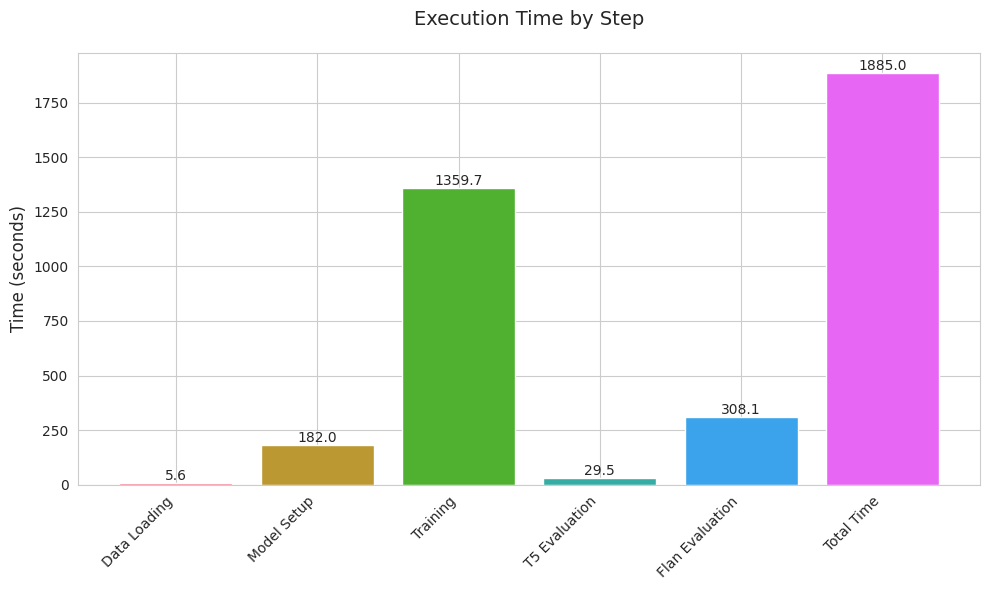


Finetuned T5-small Performance
------------------------------------------------------------
Strategy        ROUGE-1         ROUGE-2         ROUGE-L        
------------------------------------------------------------
Greedy          0.9011          0.6767          0.8990         
Beam Search     0.9055          0.6902          0.9049         
------------------------------------------------------------


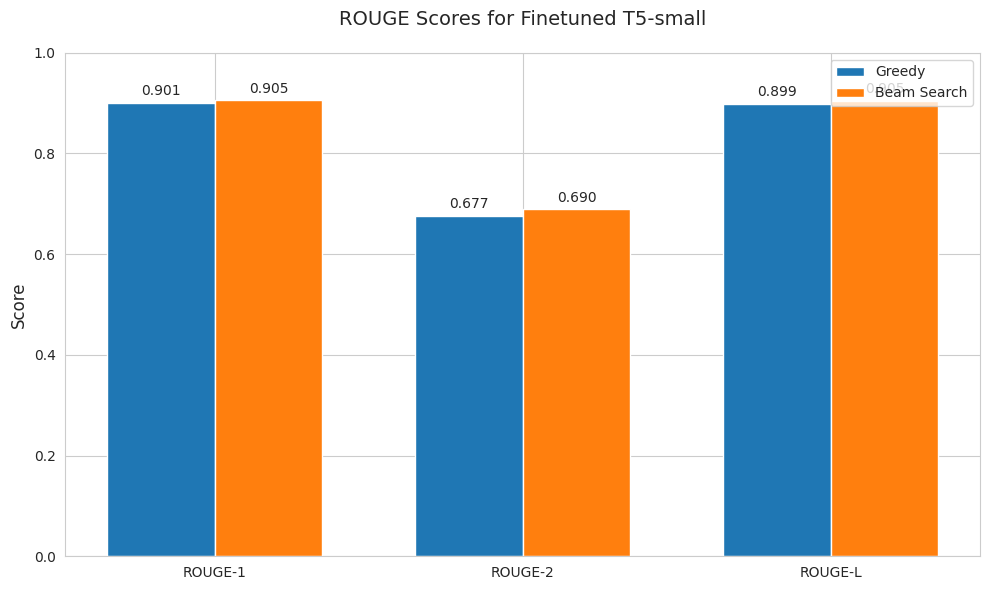


google/flan-t5-base Performance
------------------------------------------------------------
Strategy        ROUGE-1         ROUGE-2         ROUGE-L        
------------------------------------------------------------
Greedy (Basic)  0.8310          0.6050          0.8230         
Greedy (Detailed) 0.8016          0.5877          0.8007         
Beam (Basic)    0.8108          0.5763          0.8064         
Beam (Detailed) 0.8106          0.5718          0.8109         
------------------------------------------------------------


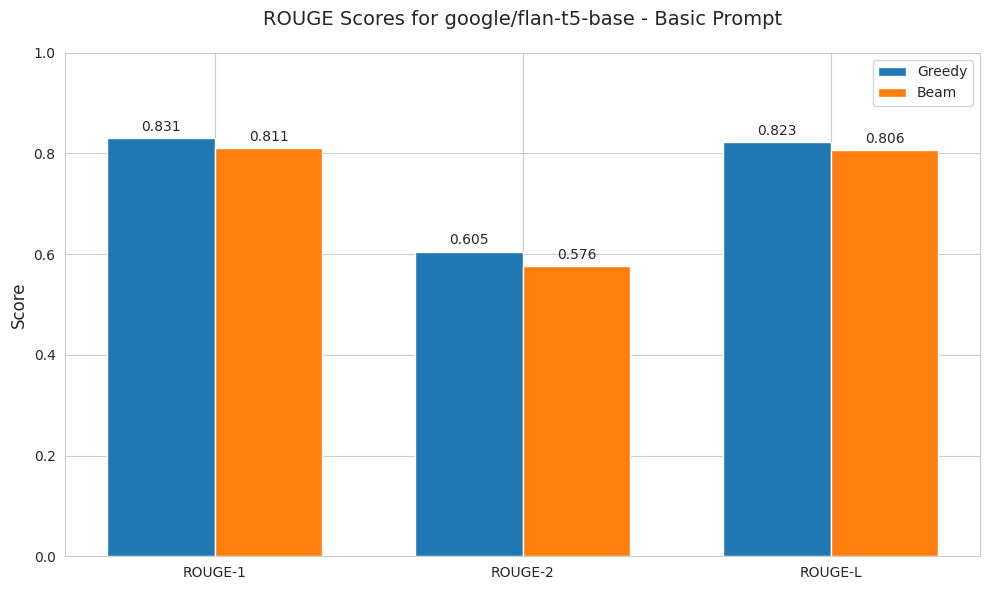

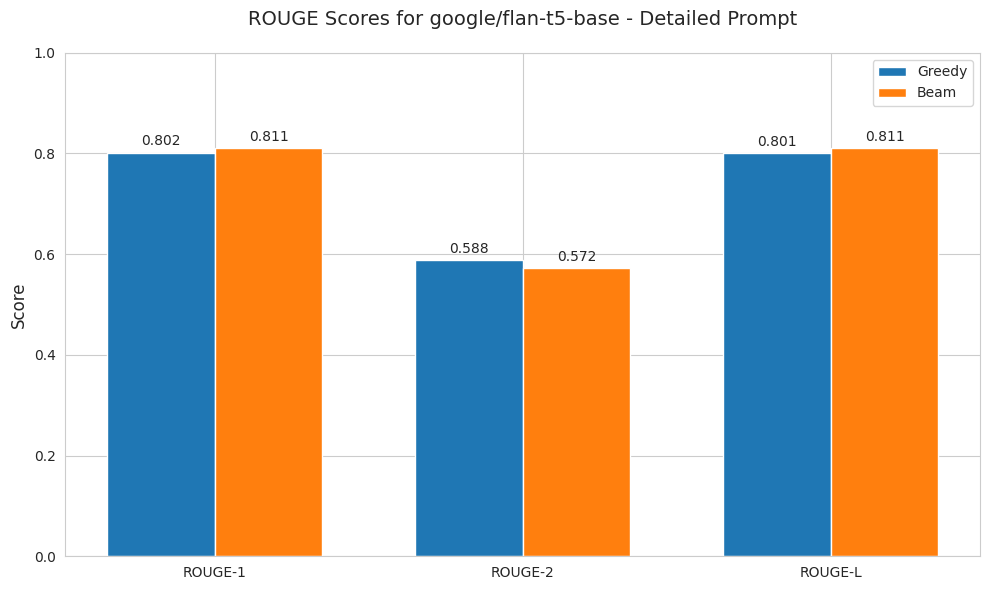


google/flan-t5-large Performance
------------------------------------------------------------
Strategy        ROUGE-1         ROUGE-2         ROUGE-L        
------------------------------------------------------------
Greedy (Basic)  0.8676          0.6582          0.8665         
Greedy (Detailed) 0.8844          0.6589          0.8845         
Beam (Basic)    0.8463          0.6231          0.8476         
Beam (Detailed) 0.8923          0.6747          0.8921         
------------------------------------------------------------


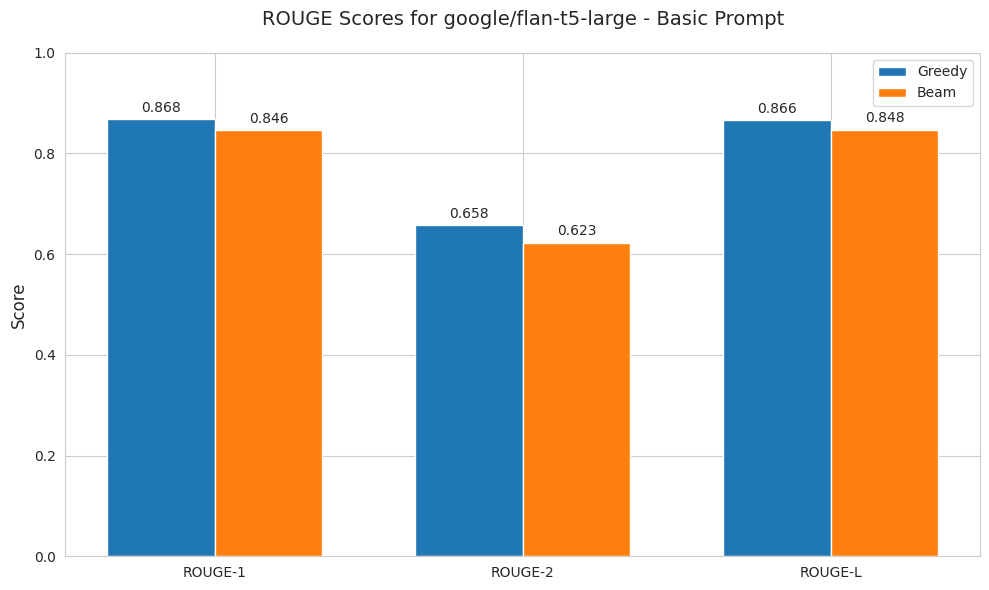

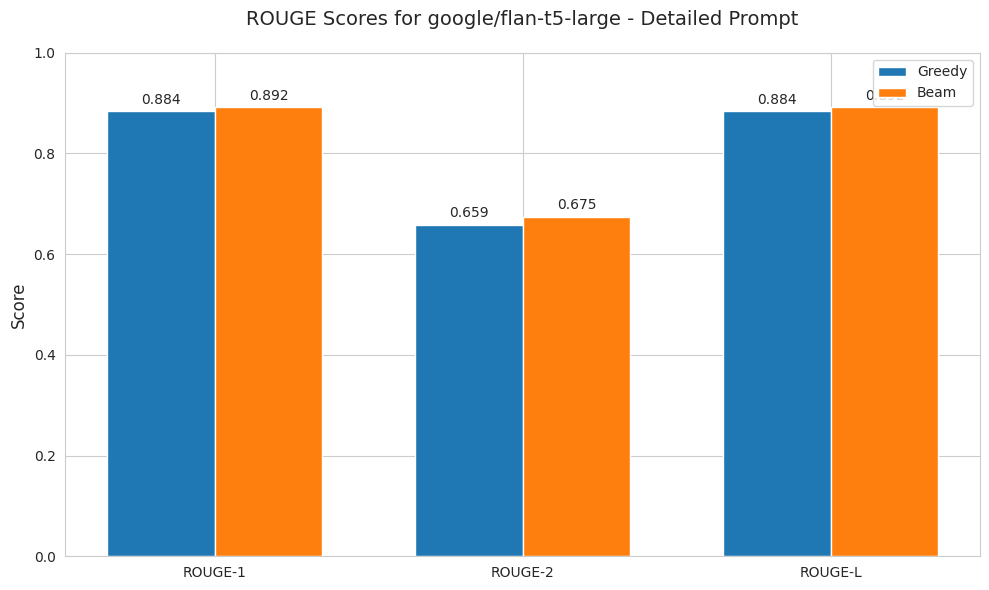

In [63]:
def main():
    total_start_time = time.time()
    timing_data = {}

    # Define paths to the CSV files.
    train_csv_path = "/content/train.csv"
    test_csv_path = "/content/test.csv"

    # Step 1: Load the datasets.
    print("\n" + "="*50)
    print("Step 1: Loading data...")
    step1_start = time.time()
    train_df, val_df, test_df = load_data(train_csv_path, test_csv_path, val_size=500)
    timing_data["Data Loading"] = time.time() - step1_start

    # Step 2: Setup model and tokenizer
    print("\n" + "="*50)
    print("Step 2: Setting up model and tokenizing data...")
    step2_start = time.time()

    t5_model_name = "google-t5/t5-small"
    t5_tokenizer = AutoTokenizer.from_pretrained(t5_model_name)
    t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_model_name).to(device)

    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)

    tokenized_train = train_dataset.map(lambda x: preprocess(x, t5_tokenizer), batched=True)
    tokenized_val = val_dataset.map(lambda x: preprocess(x, t5_tokenizer), batched=True)

    timing_data["Model Setup"] = time.time() - step2_start

    # Step 3: Training
    print("\n" + "="*50)
    print("Step 3: Training the T5-small model...")
    step3_start = time.time()

    training_args = Seq2SeqTrainingArguments(
        output_dir="./t5_results",
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        run_name="transformer",
        learning_rate=3e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        save_total_limit=3,
        predict_with_generate=True,
        fp16=True if device.type == "cuda" else False,
        report_to=[],
    )

    trainer = Seq2SeqTrainer(
        model=t5_model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=t5_tokenizer,
    )

    trainer.train()
    timing_data["Training"] = time.time() - step3_start

    # Step 4: Evaluation - T5-small decoding strategies.
    print("\n" + "="*50)
    print("Step 4: Evaluating T5-small with decoding strategies...")
    step4_start = time.time()

    rouge_metric = evaluate.load("rouge")
    t5_results = {}

    for strategy, beam in [("Greedy", False), ("Beam Search", True)]:
        print(f"\nRunning {strategy} decoding...")
        predictions = generate_titles_t5(t5_model, t5_tokenizer, test_df, beam_search=beam)

        # Print sample generated titles
        print(f"\nSample generated titles ({strategy} decoding):")
        for i in range(3):  # Print first 3 examples
            print(f"Original: {test_df['title'].iloc[i]}")
            print(f"Generated: {predictions[i]}")
            print("-" * 50)

        scores = rouge_metric.compute(predictions=predictions, references=test_df["title"].tolist())
        t5_results[strategy] = {
            "rouge1": scores['rouge1'],
            "rouge2": scores['rouge2'],
            "rougeL": scores['rougeL']
        }

    timing_data["T5 Evaluation"] = time.time() - step4_start

    # Step 5: Evaluate Flan models with various prompts.
    print("\n" + "="*50)
    print("Step 5: Evaluating Flan models with various prompts...")
    step5_start = time.time()

    prompts = {
        "Basic": "Generate a title for: {}",
        "Detailed": "Create a concise title for this Wikipedia article: {}",
    }

    flan_results = {}
    for model_size in ["base", "large"]:
        model_name = f"google/flan-t5-{model_size}"
        results = evaluate_prompts_flan(model_name, test_df, prompts)
        flan_results[model_name] = results

    timing_data["Flan Evaluation"] = time.time() - step5_start

    # Final summary
    print("\n" + "="*50)
    print("All evaluation steps completed.")
    timing_data["Total Time"] = time.time() - total_start_time

    # Visualization
    print("\n" + "="*50)
    print("Visualizing Results...")

    # Plot timing data
    plot_timing(timing_data, "Execution Time by Step")

    # Print and plot T5 results
    print_rouge_table(t5_results, "Finetuned T5-small Performance")
    plot_rouge_scores(t5_results, "Finetuned T5-small", ["Greedy", "Beam Search"])

    # Print and plot Flan results
    for model_name, results in flan_results.items():
        # Combine results for both prompts
        combined_results = {
            f"Greedy ({prompt})": res["greedy"]
            for prompt, res in results.items()
        }
        combined_results.update({
            f"Beam ({prompt})": res["beam"]
            for prompt, res in results.items()
        })

        # Extract just the ROUGE scores
        rouge_scores = {
            strategy: {k: v for k, v in scores.items() if k.startswith('rouge')}
            for strategy, scores in combined_results.items()
        }

        print_rouge_table(rouge_scores, f"{model_name} Performance")

        # Plot for each prompt type
        for prompt in prompts.keys():
            prompt_results = {
                "Greedy": results[prompt]["greedy"],
                "Beam": results[prompt]["beam"]
            }
            plot_rouge_scores(prompt_results, f"{model_name} - {prompt} Prompt", ["Greedy", "Beam"])

if __name__ == "__main__":
    main()